In [178]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_error, classification_report

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

from itertools import product


In [121]:
df_iris = pd.read_csv('iris.csv')
df_adm = pd.read_csv('admission.csv')

**БЕЙЗЛАЙН**

**Линейная регрессия**

Посмотрим на корреляцию признаков. Мультикорреляции сильно ухудшают результаты линейной регрессии. Для бейзлайна никак не будем это устранять и посмотрим на точность модели.

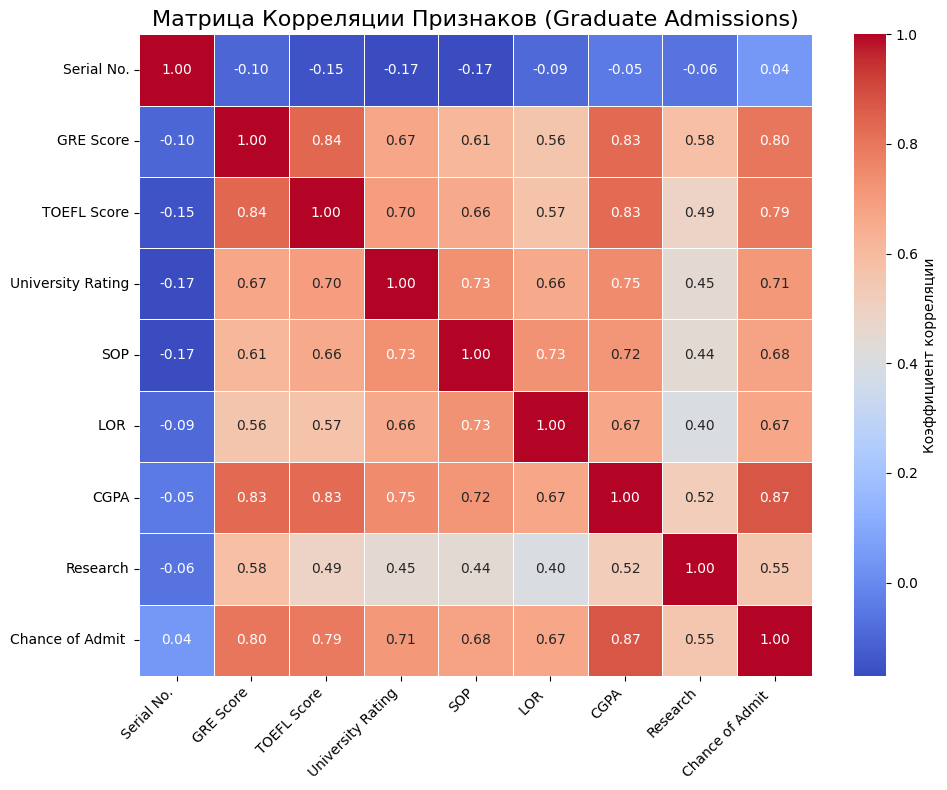

In [122]:
correlation_matrix = df_adm.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,        
    cmap='coolwarm',     
    fmt=".2f",          
    linewidths=.5,       
    cbar_kws={'label': 'Коэффициент корреляции'}
)

plt.title('Матрица Корреляции Признаков (Graduate Admissions)', fontsize=16)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

Построим бейзлайн линейной регрессии. Ничего не будем делать, просто обучим модель на исходных данных

In [130]:
df_adm.columns = df_adm.columns.str.strip().str.replace(' ', '_')

df_adm = df_adm.drop('Serial_No.', axis=1, errors='ignore')

X_reg = df_adm.drop('Chance_of_Admit', axis=1)
y_reg = df_adm['Chance_of_Admit']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

model_reg_baseline = LinearRegression()
model_reg_baseline.fit(X_train_reg, y_train_reg)

y_pred_reg_baseline = model_reg_baseline.predict(X_test_reg)
r2_baseline = r2_score(y_test_reg, y_pred_reg_baseline)
mae_baseline = mean_absolute_error(y_test_reg, y_pred_reg_baseline)

print("\nРегрессия (Linear Regression)")
print(f"Baseline R2 Score: {r2_baseline:.4f}")
print(f"Baseline MAE: {mae_baseline:.4f}")


Регрессия (Linear Regression)
Baseline R2 Score: 0.7956
Baseline MAE: 0.0495


Посмотрим на самые важные с точки зрения регрессии признаки и посмотрим на коэффициэнты при них

In [124]:
coefs = model_reg_baseline.coef_
features = X_train_reg.columns

importance = pd.DataFrame({
    'feature': features,
    'coef': coefs,
    'abs_coef': np.abs(coefs)
}).sort_values('abs_coef', ascending=False)

importance
print("\nTop features:\n", importance)


Top features:
              feature      coef  abs_coef
5               CGPA  0.117818  0.117818
6           Research  0.018439  0.018439
4                LOR  0.013695  0.013695
2  University_Rating  0.004866  0.004866
1        TOEFL_Score  0.003171  0.003171
0          GRE_Score  0.001840  0.001840
3                SOP  0.000995  0.000995


**Логистическая регрессия**

Обучим бейзлайн классификации без предварительных манипуляций с данными. Выделим предикторы и целевую переменную. Разобьем выборку на трейн и тест.

In [131]:
df_iris['species'] = df_iris['species'].astype('category').cat.codes

X_clf = df_iris.drop('species', axis=1)
y_clf = df_iris['species']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)


model_clf_baseline = LogisticRegression(max_iter=300, random_state=42)
model_clf_baseline.fit(X_train_clf, y_train_clf)

# b. Оценка качества
y_pred_clf_baseline = model_clf_baseline.predict(X_test_clf)
accuracy_baseline = accuracy_score(y_test_clf, y_pred_clf_baseline)

print("Классификация (Logistic Regression)")
print(f"Baseline Accuracy: {accuracy_baseline:.4f}")
print("\nClassification Report:\n", classification_report(y_test_clf, y_pred_clf_baseline))

Классификация (Logistic Regression)
Baseline Accuracy: 0.9667

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



Построим матрицу ошибок

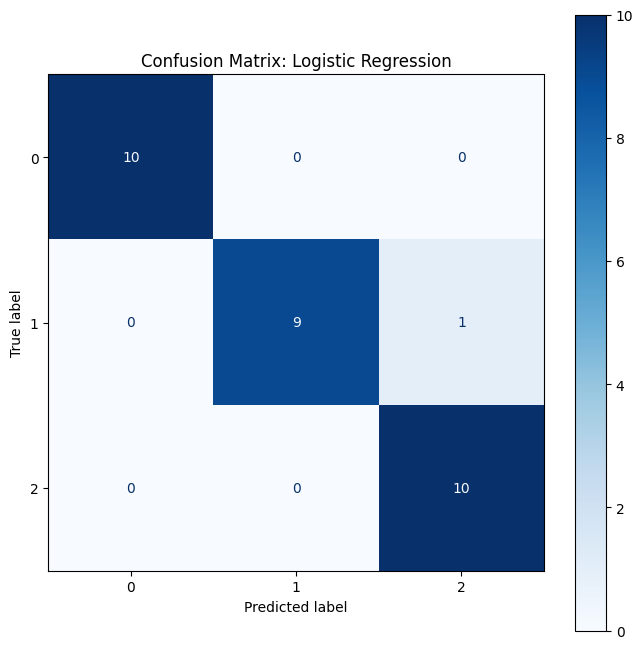

In [132]:
cm = confusion_matrix(y_test_clf, y_pred_clf_baseline)

class_names = df_iris['species'].astype('category').cat.categories.tolist()

# Строим и отображаем график
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix: Logistic Regression')
plt.show()

**Результаты:** Мы получили отличный показатель, но все же по матрице признаков видно, что есть путаница между 1 и 2 классами.

**Линейная регрессия. Улучшения.**

Добавим в код поиск параметров по сетке и регуляризацию в регрессию. Будем использовать ElasticNet регрессию, что является своего рода суммой L2 и L1 регрессий. Таким образом, ElasticNet совмещает в себе преимущество обоих типов регуляризации, делая модель устойчивее к мультикорреляциям и приводя к нулю коэффициенты незначимых признаков.

In [106]:
df_adm.columns = df_adm.columns.str.strip().str.replace(' ', '_')
df_adm = df_adm.drop('Serial_No.', axis=1, errors='ignore')

X = df_adm.drop('Chance_of_Admit', axis=1)
y = df_adm['Chance_of_Admit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet(max_iter=1000))
])

params = {
    'model__alpha': np.linspace(0.01,1,20),
    'model__l1_ratio': np.linspace(0.01,1,20)
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nGridSearch Results")
print("Best params:", grid.best_params_)
print(f"R2:  {r2:.4f}")
print(f"MAE: {mae:.4f}")



GridSearch Results
Best params: {'model__alpha': 0.01, 'model__l1_ratio': 0.21842105263157896}
R2:  0.7915
MAE: 0.0498


Посмотрим, какие фичи были наиболее важны с точки зрения новой модели. Будем смотреть на коэффициенты при признаке.

In [107]:
coefs_best_model = best_model.named_steps['model'].coef_
features_best = X_train.columns

importance_best = pd.DataFrame({
    'feature': features_best,
    'coef': coefs_best_model,
    'abs_coef': np.abs(coefs_best_model)
}).sort_values('abs_coef', ascending=False)

print("\nTop features:\n", importance_best)


Top features:
              feature      coef  abs_coef
5               CGPA  0.068102  0.068102
0          GRE_Score  0.021284  0.021284
1        TOEFL_Score  0.018799  0.018799
4                LOR  0.011844  0.011844
6           Research  0.007978  0.007978
2  University_Rating  0.005595  0.005595
3                SOP  0.001044  0.001044


**Результат:** получили практически идентичные результаты, что и в бейзлайне. Я предполагаю, что это связано с тем, что структура датасета очень простая, поэтому манипуляции с регуляризацией и подбором параметров вносят незначительный вклад.

**Логистическая регрессия. Улучшения.**

In [135]:
df_iris['species'] = df_iris['species'].astype('category').cat.codes

X = df_iris.drop('species', axis=1)
y = df_iris['species']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000))
])

param_grid = {
    'poly__degree': [1, 2, 3], 
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['liblinear']
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("\nLogistic Regression: Improved")
print("Best params:\n", grid.best_params_)

print("Классификация улучшенная")
print(f"\nAccuracy: {accuracy:.4f}")
print("Классификация бейзлайн")
print(f"Baseline Accuracy: {accuracy_baseline:.4f}")
print("Разница")
print(f"{accuracy - accuracy_baseline:.4f}")



print("\nClassification Report:\n", classification_report(y_test, y_pred))


Logistic Regression: Improved
Best params:
 {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'poly__degree': 3}
Классификация улучшенная

Accuracy: 1.0000
Классификация бейзлайн
Baseline Accuracy: 0.9667
Разница
0.0333

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



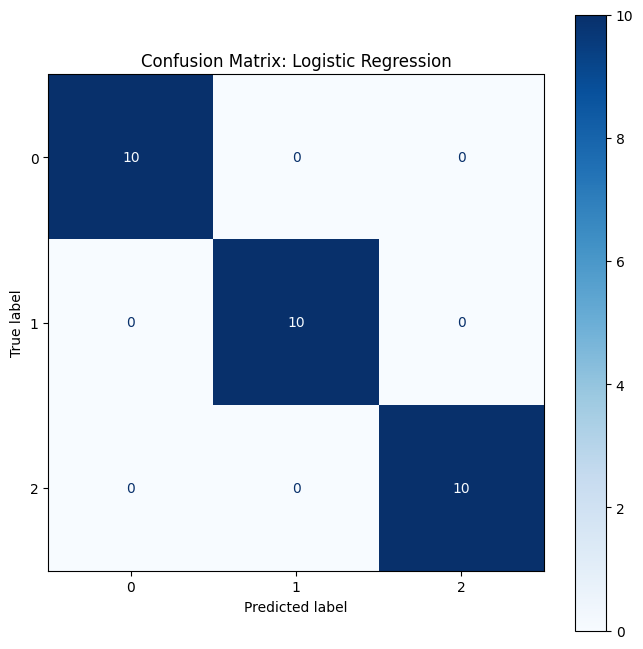

In [134]:
cm = confusion_matrix(y_test, y_pred)

class_names = df_iris['species'].astype('category').cat.categories.tolist()

# Строим и отображаем график
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix: Logistic Regression')
plt.show()

**Результат:** Видим улучшение по сравнению с безйлайном. Весьма эффективно введение полиномиальных признаков и регуляризации.

**ИМПЛЕМЕНТАЦИЯ**

**Логистическая регрессия**

Переиспользуем некоторые функции из прошлой лабораторной работы

In [139]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    return correct_predictions / total_samples

In [155]:
def train_test_split_custom(X, y, test_size=0.3, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

In [252]:
def custom_k_fold_split(X, y, n_splits=5, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1
    
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_indices = indices[start:stop]
        train_indices = np.concatenate([indices[:start], indices[stop:]])
        yield (train_indices, test_indices)
        current = stop

def custom_grid_search(X_train, y_train, model_class, param_grid,
                       n_splits=5, scoring='r2'):
    
    maximize_metrics = {'accuracy', 'r2', 'f1'}
    minimize_metrics = {'mae', 'mse'}
    
    if scoring in maximize_metrics:
        compare = lambda new, best: new > best
        best_score = -np.inf
    elif scoring in minimize_metrics:
        compare = lambda new, best: new < best
        best_score = np.inf
    else:
        raise ValueError(f"Метрика '{scoring}' не поддерживается")

    best_params = None

    keys, values = zip(*param_grid.items())
    
    for params in product(*values):
        param_dict = dict(zip(keys, params))
        fold_scores = []

        for tr_idx, val_idx in custom_k_fold_split(X_train, y_train, n_splits=n_splits):
            X_tr, X_val = X_train[tr_idx], X_train[val_idx]
            y_tr, y_val = y_train[tr_idx], y_train[val_idx]

            model = model_class(**param_dict)
            model.fit(X_tr, y_tr)
            pred = model.predict(X_val)

            if scoring == 'r2':
                score = calculate_r2(y_val, pred)
            elif scoring == 'mae':
                score = calculate_mae(y_val, pred)
            elif scoring == 'accuracy':
                score = np.mean(y_val == pred)
            else:
                raise ValueError(f"Метрика '{scoring}' не поддерживается")

            fold_scores.append(score)

        mean_score = np.mean(fold_scores)

        print(f"{param_dict} -> {scoring}={mean_score:.4f}")

        if compare(mean_score, best_score):
            best_score = mean_score
            best_params = param_dict

    return best_params, best_score


Теперь реализуем класс логистичечкой регрессии. У нас задача многоклассовой классификации. Решение задачи многоклассовой классификации с помощью линейной регрессии абсолютно эквивалентно использованию перцептрона с одним слоем и функцией активации софтмакс на конце. Поэтому нам нужно будет реализовать софтмакс.

In [142]:
class LogisticRegression:
    def __init__(self, lr=0.1, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.W = None
        self.b = None

    def _softmax(self, z):
        exp = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def _one_hot(self, y, n_classes):
        one_hot = np.zeros((y.shape[0], n_classes))
        one_hot[np.arange(y.shape[0]), y] = 1
        return one_hot

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_classes = np.max(y) + 1

        self.W = np.zeros((n_features, n_classes))
        self.b = np.zeros((1, n_classes))

        y_one_hot = self._one_hot(y, n_classes)

        for i in range(self.n_iters):
            logits = X.dot(self.W) + self.b
            probs = self._softmax(logits)

            grad_W = (1 / n_samples) * X.T.dot(probs - y_one_hot)
            grad_b = (1 / n_samples) * np.sum(probs - y_one_hot, axis=0, keepdims=True)

            self.W -= self.lr * grad_W
            self.b -= self.lr * grad_b

    def predict(self, X):
        logits = X.dot(self.W) + self.b
        probs = self._softmax(logits)
        return np.argmax(probs, axis=1)

Применим уже реализованную ранее функцию для разделения выборки и обучим классификатор

In [173]:
df_iris['species'] = df_iris['species'].astype('category').cat.codes

X = df_iris.drop('species', axis=1).values
y = df_iris['species'].values

X_train, X_test, y_train, y_test = train_test_split_custom(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(lr=0.1, n_iters=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = calculate_accuracy(y_test, y_pred)
print("Accuracy (from-scratch logistic regression):", acc)

Accuracy (from-scratch logistic regression): 1.0


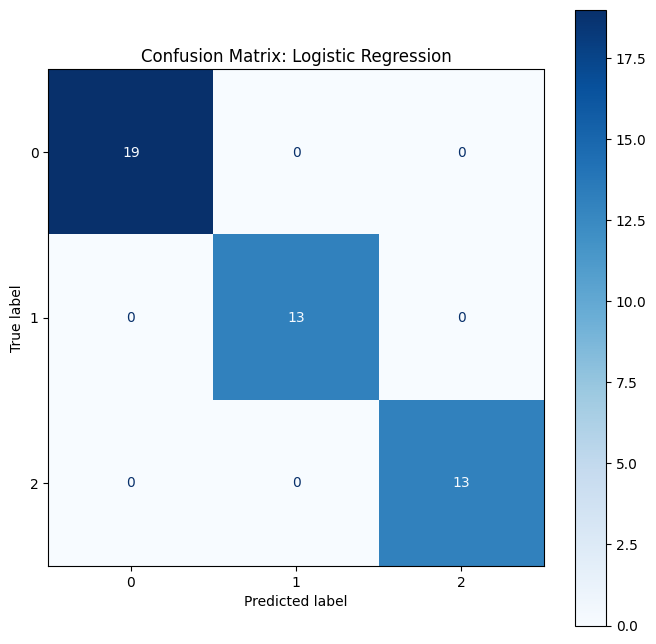

In [174]:
cm = confusion_matrix(y_test, y_pred)

class_names = df_iris['species'].astype('category').cat.categories.tolist()

# Строим и отображаем график
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix: Logistic Regression')
plt.show()

**Результаты:** Мы получили идеальный резульат. В других ситуациях можно было бы грешить на переобучение модели в случае, если на тестовой выборке получается максимальная метрика, но в нашем случае есть несколько причин на то, чтобы не делать такие выводы. Во-первых, мы используем модель логистической регресии, которая сама по себе по своему математическому смыслу не переобучается. Во-вторых датасет небольшой и классы хорошо отделимы друг от друга.

Мы уже получили идеальный резульат, но в целях обучения дополним наш класс регрессии регуляризацией и обучим регрессию с регуляризацией и подбором гиперпараметров по сетке

In [188]:
class LogisticRegressionReg:
    def __init__(self, lr=0.1, n_iters=1000, reg_type=None, reg_strength=0.0):

        self.lr = lr
        self.n_iters = n_iters
        self.reg_type = reg_type
        self.reg_strength = reg_strength
        self.W = None
        self.b = None

    def _softmax(self, z):
        exp = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def _one_hot(self, y, n_classes):
        oh = np.zeros((y.shape[0], n_classes))
        oh[np.arange(y.shape[0]), y] = 1
        return oh

    def _regularization_grad(self):
        if self.reg_type == "l2":
            return self.reg_strength * self.W
        elif self.reg_type == "l1":
            return self.reg_strength * np.sign(self.W)
        else:
            return 0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_classes = np.max(y) + 1

        self.W = np.zeros((n_features, n_classes))
        self.b = np.zeros((1, n_classes))

        y_one_hot = self._one_hot(y, n_classes)

        for _ in range(self.n_iters):
            logits = X.dot(self.W) + self.b
            probs = self._softmax(logits)

            grad_W = (1/n_samples) * X.T.dot(probs - y_one_hot)
            grad_b = (1/n_samples) * np.sum(probs - y_one_hot, axis=0, keepdims=True)

            grad_W += self._regularization_grad()

            self.W -= self.lr * grad_W
            self.b -= self.lr * grad_b

    def predict(self, X):
        logits = X.dot(self.W) + self.b
        probs = self._softmax(logits)
        return np.argmax(probs, axis=1)


Определим сетку гиперпараметров

In [180]:
param_grid = {
    "lr": [0.01, 0.1],
    "n_iters": [500, 1500],
    "reg_type": [None, "l2", "l1"],
    "reg_strength": [0.0, 0.01, 0.1]
}

Найдем оптимальные гиперпараметры

In [186]:
best_params, best_score = custom_grid_search(
    X_train, y_train,
    model_class=LogisticRegressionReg,
    param_grid=param_grid,
    n_splits=5
)

print("\nBEST PARAMS:", best_params)
print("BEST CV ACC:", best_score)

{'lr': 0.01, 'n_iters': 500, 'reg_type': None, 'reg_strength': 0.0} -> acc=0.9238
{'lr': 0.01, 'n_iters': 500, 'reg_type': None, 'reg_strength': 0.01} -> acc=0.9238
{'lr': 0.01, 'n_iters': 500, 'reg_type': None, 'reg_strength': 0.1} -> acc=0.9238
{'lr': 0.01, 'n_iters': 500, 'reg_type': 'l2', 'reg_strength': 0.0} -> acc=0.9238
{'lr': 0.01, 'n_iters': 500, 'reg_type': 'l2', 'reg_strength': 0.01} -> acc=0.9238
{'lr': 0.01, 'n_iters': 500, 'reg_type': 'l2', 'reg_strength': 0.1} -> acc=0.8857
{'lr': 0.01, 'n_iters': 500, 'reg_type': 'l1', 'reg_strength': 0.0} -> acc=0.9238
{'lr': 0.01, 'n_iters': 500, 'reg_type': 'l1', 'reg_strength': 0.01} -> acc=0.8857
{'lr': 0.01, 'n_iters': 500, 'reg_type': 'l1', 'reg_strength': 0.1} -> acc=0.7143
{'lr': 0.01, 'n_iters': 1500, 'reg_type': None, 'reg_strength': 0.0} -> acc=0.9619
{'lr': 0.01, 'n_iters': 1500, 'reg_type': None, 'reg_strength': 0.01} -> acc=0.9619
{'lr': 0.01, 'n_iters': 1500, 'reg_type': None, 'reg_strength': 0.1} -> acc=0.9619
{'lr': 0.

In [187]:
best_model = LogisticRegressionReg(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
test_acc = calculate_accuracy(y_test, y_pred)

print("\nTEST ACC:", test_acc)


TEST ACC: 1.0


**Результаты:** Мы получили все так же идеальный результат про вышеописанным причинам.

**Сравнение с библиотечной версией**: И в бейзлайне, и в улучшенной версии, мы получили примерно одинаковыйе результаты, по метрике близкие к 1. Я предполагаю, что так получается из-за малой сложности в данных и пока еще примитивности алгоритма модели.

**Линейная регрессия**

Переиспользуем фукнции из предыдущей лр

In [197]:
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_r2(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_res = np.sum((y_true - y_pred)**2)
    
    ss_tot = np.sum((y_true - y_mean)**2)
    if ss_tot == 0:
        return 1.0
        
    return 1 - (ss_res / ss_tot)
class CustomStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        self.scale_[self.scale_ == 0] = 1.0 
        return self

    def transform(self, X):
        if self.mean_ is None or self.scale_ is None:
            raise RuntimeError("Scaler не обучен. Вызовите 'fit' перед 'transform'.")
        return (X - self.mean_) / self.scale_

Реализуем класс линейной регрессии. Центральный алгоритм - градиентный спуск, который используется при обучении линейной и логистических регрессий. Необходимо определить градиент относительно матрицы весов, определить шаг и сместить веса в сторону этого шага. Этот процесс будет итеративно повторяться в методе fit.

In [205]:
class LinearRegressionCustom:
    def __init__(self, lr=0.001, n_iters=2000):
        self.lr = lr
        self.n_iters = n_iters
        self.W = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        self.W = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            y_pred = X.dot(self.W) + self.b
            error = y_pred - y

            dW = (2/n_samples) * X.T.dot(error)
            db = (2/n_samples) * np.sum(error)

            self.W -= self.lr * dW
            self.b -= self.lr * db

    def predict(self, X):
        return X.dot(self.W) + self.b


In [201]:
df_adm.columns = df_adm.columns.str.strip()
df_adm = df_adm.drop("Serial_No.", axis=1, errors="ignore")

In [215]:
X = df_adm.drop("Chance_of_Admit", axis=1).values
y = df_adm["Chance_of_Admit"].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = CustomStandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_custom = LinearRegressionCustom(lr=0.01, n_iters=5000)
model_custom.fit(X_train_scaled, y_train)

y_pred = model_custom.predict(X_test_scaled)

mae = calculate_mae(y_test, y_pred)
r2 = calculate_r2(y_test, y_pred)

print("R2:", round(r2, 4))
print("MAE:", round(mae, 4))

R2: 0.7956
MAE: 0.0495


Мы получили абсолютно идентичные результаты с библиотечной моделью. Алгоритм несложен в реализации и результаты получаются идентичные с точностью до рандом стейта и разбиения выборки

**Линейная регрессия. Имплементация регуляризации и подбора гиперпараметров.**

Имплементируем регуляризацию. Добавим к градиенту еще градиент от регуляризационного члена.

In [ ]:
def custom_grid_search_reg(X_train, y_train, model_class, param_grid, n_splits=5):

    best_score = -np.inf
    best_params = None

    keys, values = zip(*param_grid.items())

    for params in product(*values):
        param_dict = dict(zip(keys, params))
        fold_scores = []

        for train_idx, val_idx in custom_k_fold_split(X_train, y_train, n_splits=n_splits):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            model = model_class(**param_dict)
            model.fit(X_tr, y_tr)
            pred = model.predict(X_val)

            fold_scores.append(calculate_r2(y_val, pred))

        mean_score = np.mean(fold_scores)
        print(f"{param_dict} -> R2={mean_score:.4f}")

        if mean_score > best_score:
            best_score = mean_score
            best_params = param_dict

    return best_params, best_score


In [231]:
class LinearRegressionCustomReg:
    def __init__(self, lr=0.01, n_iters=1000, reg=None, lam=0.0):

        self.lr = lr
        self.n_iters = n_iters
        self.reg = reg
        self.lam = lam
        self.w = None
        self.b = None

    def _regularization_gradient(self, w):
        if self.reg == "l2":
            return 2 * self.lam * w
        elif self.reg == "l1":
            return self.lam * np.sign(w)
        return 0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            y_pred = X.dot(self.w) + self.b
            error = y_pred - y

            dw = (2/n_samples) * X.T.dot(error) + self._regularization_gradient(self.w)
            db = (2/n_samples) * np.sum(error)

            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict(self, X):
        return X.dot(self.w) + self.b

Подготовим и отскалируем данные

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

scaler = CustomStandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Определим сетку параметров и найдем оптимальные 

In [250]:
param_grid = {
    "lr": [0.01, 0.005],
    "n_iters": [800, 1200],
    "reg": ["l2", "l1"],
    "lam": [0.0, 0.1, 0.5],
}

best_params, best_score = custom_grid_search(
    X_train_scaled, y_train,
    LinearRegressionCustomReg, param_grid,
    n_splits=5, scoring='mae'
)

print("\nЛучшие параметры:", best_params)
print("CV R2 =", best_score)

{'lr': 0.01, 'n_iters': 800, 'reg': 'l2', 'lam': 0.0} -> mae=0.0459
{'lr': 0.01, 'n_iters': 800, 'reg': 'l2', 'lam': 0.1} -> mae=0.0455
{'lr': 0.01, 'n_iters': 800, 'reg': 'l2', 'lam': 0.5} -> mae=0.0479
{'lr': 0.01, 'n_iters': 800, 'reg': 'l1', 'lam': 0.0} -> mae=0.0459
{'lr': 0.01, 'n_iters': 800, 'reg': 'l1', 'lam': 0.1} -> mae=0.0667
{'lr': 0.01, 'n_iters': 800, 'reg': 'l1', 'lam': 0.5} -> mae=0.1061
{'lr': 0.01, 'n_iters': 1200, 'reg': 'l2', 'lam': 0.0} -> mae=0.0459
{'lr': 0.01, 'n_iters': 1200, 'reg': 'l2', 'lam': 0.1} -> mae=0.0455
{'lr': 0.01, 'n_iters': 1200, 'reg': 'l2', 'lam': 0.5} -> mae=0.0479
{'lr': 0.01, 'n_iters': 1200, 'reg': 'l1', 'lam': 0.0} -> mae=0.0459
{'lr': 0.01, 'n_iters': 1200, 'reg': 'l1', 'lam': 0.1} -> mae=0.0667
{'lr': 0.01, 'n_iters': 1200, 'reg': 'l1', 'lam': 0.5} -> mae=0.1064
{'lr': 0.005, 'n_iters': 800, 'reg': 'l2', 'lam': 0.0} -> mae=0.0457
{'lr': 0.005, 'n_iters': 800, 'reg': 'l2', 'lam': 0.1} -> mae=0.0456
{'lr': 0.005, 'n_iters': 800, 'reg': 'l2

Обучим модель и посмотрим на метрики

In [251]:
model = LinearRegressionCustomReg(**best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

mae = calculate_mae(y_test, y_pred)
r2 = calculate_r2(y_test, y_pred)

print("\nФинальные результаты")
print("R2:", round(r2, 4))
print("MAE:", round(mae, 4))


Финальные результаты
R2: 0.8114
MAE: 0.0489


**Результаты и сравнение с библиотечной моделью:** В самописном классе линейной регрессии мы улучшили результат, добавив регуляризацию и поиск оптимальных гиперпараметров по сетке с кросс-валидацией. Результаты даже улучшились по сравнению с библиотечной реализацией кросс-валидации, но незначительно. Эту незначительность повлекло изменение random-state для разделения выборки на тренировочную и тестовую часть. В целом мы получаем похожие результаты и для библиотечных, и для сапомисных версий, с точностью до random-state, т.е случайного разбиения.